In [43]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# 1. Создание карты с кластерными метками:

*Кластерные метки* - это метки на карте, которые при отдалении схлопываются в объединенные кружочки (для экономии ресурса)

In [3]:
# создаем тестовый датафрейм:

import pandas as pd

data = {
    'latitude': [40.7128, 34.0522, 41.8781, 51.5074, 37.7749, 33.6844, 39.9042, 48.8566, 35.682839, 55.7558],
    'longitude': [-74.0060, -118.2437, -87.6298, -0.1278, -122.4194, -117.8265, 32.9297, 2.3522, 139.759455, 37.6176],
    'name': ['New York', 'Los Angeles', 'Chicago', 'London', 'San Francisco', 'San Diego', 'Beijing', 'Paris', 'Tokyo', 'Moscow']
}

df = pd.DataFrame(data)

df.head()

,latitude,longitude,name
0,40.7128,-74.0060,New York
1,34.0522,-118.2437,Los Angeles
2,41.8781,-87.6298,Chicago
3,51.5074,-0.1278,London
4,37.7749,-122.4194,San Francisco


In [50]:
import folium
from folium.plugins import MarkerCluster

map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=2)

# Create a MarkerCluster
marker_cluster = MarkerCluster().add_to(map)

# Add markers to the cluster
for _, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name']
    ).add_to(marker_cluster)

# Display the map
map

# 2. Как нарисовать polygon вручную:

Cайт: https://geojson.io

Это сайт где можно интерактивно нарисовать на карте произвольный полигон и получить его код в виде geojson.

Например, мы нарисовали полигон и скопировали справа его geojson:

In [10]:
from shapely.geometry import Polygon

In [11]:
# функция, конвертирующая geojson в Polygon:

def get_polygon_from_dict(geojson):
    coordinates_list = geojson['features'][0]['geometry']['coordinates'][0]
    return Polygon(coordinates_list)

In [17]:
# geojson МКАДа (нарисовали на https://geojson.io):

mkad_geojson = \
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              37.36773395055624,
              55.72929672787845
            ],
            [
              37.50678467194513,
              55.60452974307799
            ],
            [
              37.67742371234735,
              55.5795303356455
            ],
            [
              37.83547407889503,
              55.658050034561654
            ],
            [
              37.84493539573907,
              55.80751728021505
            ],
            [
              37.72167845864138,
              55.88734742173864
            ],
            [
              37.56682932930957,
              55.91037857344125
            ],
            [
              37.39618717366926,
              55.864282386046455
            ],
            [
              37.36773395055624,
              55.72929672787845
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [16]:
# получаем полигон:
mkad_polygon = get_polygon_from_dict(mkad_geojson)

In [15]:
type(mkad_polygon)

shapely.geometry.polygon.Polygon

# 3. Создание карты с полигонами:

In [18]:
import folium

In [44]:
# простая карта:

m = folium.Map(location=[55.7558, 37.6176], zoom_start=9)

folium.GeoJson(mkad_polygon).add_to(m)

m

In [45]:
# Добавляем цвет и аттрибуты полигону:

m = folium.Map(location=[55.7558, 37.6176], zoom_start=9)

folium.GeoJson(
    mkad_polygon,
    style_function=lambda feature: { # цвет полигона
        'color': 'red',
        'weight': 2,
        'fillOpacity': 0.5},
    
    tooltip=folium.Tooltip('мкад') # всплывающая надпись
    
).add_to(m)

# display the map:
m

# 4. Объединение полигонов:

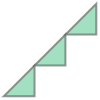

In [49]:
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

# примеры полигонов:
polygon1 = Polygon([(0, 0), (1, 0), (1, 1)])
polygon2 = Polygon([(1, 1), (2, 1), (2, 2)])
polygon3 = Polygon([(2, 2), (3, 2), (3, 3)])

# объединяем:
list_of_polygons = [polygon1, polygon2, polygon3]
united_polygon = cascaded_union(list_of_polygons)

united_polygon

# 5. Как записать полигон в виде строки и конвертировать обратно в shapely.geometry.polygon.Polygon:

In [60]:
from shapely.geometry import Polygon
from shapely import wkt

# пример полигона:
polygon1 = Polygon([(0, 0), (1, 0), (1, 1)])

# конвертируем в строку:
str_polygon = str(polygon1)

# конвертируем в полигон:
polygon2 = wkt.loads(str_polygon)
type(polygon2)

shapely.geometry.polygon.Polygon